In [1]:
from mint.config import DATA_DIR
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Kiến trúc dữ liệu

In [2]:
# Đường dẫn thư mục chứa dữ liệu
data_dir = DATA_DIR("MathQA")
files = ['train.json', 'test.json', 'dev.json', 'challenge_test.json']

# Đọc toàn bộ dữ liệu từ các file JSON vào DataFrame
def load_json_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return pd.json_normalize(json.load(f))
# Nạp dữ liệu
datasets = {fname.replace('.json', ''): load_json_data(os.path.join(data_dir, fname)) for fname in files}

### Giải thích sơ về bộ dữ liệu:
- Problem: câu hỏi toán bằng ngôn ngữ tự nhiên
- Rationable: lời giải hoặc diễn giải bằng văn bản cách giải
- Options: danh sách các phương án trả lời (a,b,c,d,e)
- Correct: hãn đáp án đúng (ví dụ: c)
- Annotated_formula: công thức toán có cấu trúc, biểu diễn quá trình tính toán để đi đến kết quả
- Linear_formula: Dạng tuyến tính của công thức, biểu diễn quá trình tính toán theo từng bước
- Category: Nhóm bài toán


### Giải thích vai trò các tập dữ liệu:
- train: dùng để huấn luyện mô hình
- dev: dùng để điều chỉnh tham số mô hình và chọn mô hình tốt nhất
- test: đánh giá cuối cùng hiệu quả của mô hình sau khi đã huấn luyện, tinh chỉnh
- challenge_test: kiểm tra mô hình trên những trường hợp đặc biệt hoặc khó hơn so với test thường

In [3]:
# Hiển thị số lượng mẫu và các cột
for name, df in datasets.items():
    print(f"\nDataset: {name}")
    print(f"Số lượng mẫu: {len(df)}")
    print(f"Các cột: {df.columns.tolist()}")
    display(df.info()) 

# Tạo một cột mới: length_problem, length_rationale để phân tích độ dài
for df in datasets.values():
    df['len_problem'] = df['Problem'].apply(len)
    df['len_rationale'] = df['Rationale'].apply(len)
    df['len_formula'] = df['annotated_formula'].apply(lambda x: len(str(x)))


Dataset: train
Số lượng mẫu: 29837
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29837 entries, 0 to 29836
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Problem            29837 non-null  object
 1   Rationale          29837 non-null  object
 2   options            29837 non-null  object
 3   correct            29837 non-null  object
 4   annotated_formula  29837 non-null  object
 5   linear_formula     29837 non-null  object
 6   category           29837 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB


None


Dataset: test
Số lượng mẫu: 2985
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985 entries, 0 to 2984
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Problem            2985 non-null   object
 1   Rationale          2985 non-null   object
 2   options            2985 non-null   object
 3   correct            2985 non-null   object
 4   annotated_formula  2985 non-null   object
 5   linear_formula     2985 non-null   object
 6   category           2985 non-null   object
dtypes: object(7)
memory usage: 163.4+ KB


None


Dataset: dev
Số lượng mẫu: 4475
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Problem            4475 non-null   object
 1   Rationale          4475 non-null   object
 2   options            4475 non-null   object
 3   correct            4475 non-null   object
 4   annotated_formula  4475 non-null   object
 5   linear_formula     4475 non-null   object
 6   category           4475 non-null   object
dtypes: object(7)
memory usage: 244.9+ KB


None


Dataset: challenge_test
Số lượng mẫu: 604
Các cột: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Problem            604 non-null    object
 1   Rationale          604 non-null    object
 2   options            604 non-null    object
 3   correct            604 non-null    object
 4   annotated_formula  604 non-null    object
 5   linear_formula     604 non-null    object
 6   category           604 non-null    object
dtypes: object(7)
memory usage: 33.2+ KB


None

In [4]:
for name, df in datasets.items():
    print(f"--- {name} Dataset ---")
    display(df.head()) 
    print("\n")

--- train Dataset ---


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category,len_problem,len_rationale,len_formula
0,the banker ' s gain of a certain sum due 3 yea...,"""explanation : t = 3 years r = 10 % td = ( bg ...","a ) rs . 400 , b ) rs . 300 , c ) rs . 500 , d...",a,"divide(multiply(const_100, divide(multiply(36,...","multiply(n2,const_100)|multiply(n0,n1)|divide(...",gain,113,220,94
1,average age of students of an adult school is ...,"""explanation : let the original no . of studen...","a ) 1200 , b ) 120 , c ) 360 , d ) 240 , e ) n...",d,"multiply(divide(subtract(multiply(add(32, 4), ...","add(n2,n3)|multiply(n1,n2)|multiply(n1,#0)|sub...",general,255,215,101
2,sophia finished 2 / 3 of a book . she calculat...,let xx be the total number of pages in the boo...,"a ) 229 , b ) 270 , c ) 877 , d ) 266 , e ) 281",b,"divide(90, subtract(const_1, divide(2, 3)))","divide(n0,n1)|subtract(const_1,#0)|divide(n2,#1)",general,130,277,43
3,120 is what percent of 50 ?,"""50 * x = 120 - - > x = 2.4 - - > 2.4 expresse...","a ) 5 % , b ) 240 % , c ) 50 % , d ) 2 % , e )...",b,"multiply(divide(120, 50), const_100)","divide(n0,n1)|multiply(#0,const_100)|",gain,27,83,36
4,there are 10 girls and 20 boys in a classroom ...,"if girls is 10 and boys is 20 , then 10 / 20 ....","a ) 1 / 2 , b ) 1 / 3 , c ) 1 / 5 , d ) 10 / 3...",a,"divide(10, 20)","divide(n0,n1)",other,84,104,14




--- test Dataset ---


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category,len_problem,len_rationale,len_formula
0,a shopkeeper sold an article offering a discou...,"""giving no discount to customer implies sellin...","a ) 38 , b ) 27.675 , c ) 30 , d ) data inadeq...",a,"subtract(divide(multiply(add(const_100, 31.1),...","add(n1,const_100)|subtract(const_100,n0)|multi...",gain,174,252,94
1,what will be the difference between simple and...,"""s . i . = ( 1000 * 14 * 4 ) / 100 = rs . 560 ...","a ) 129 , b ) 130 , c ) 124 , d ) 133 , e ) 145",a,"subtract(subtract(multiply(1000, power(add(div...","divide(n0,const_100)|add(#0,const_1)|multiply(...",gain,120,153,139
2,there are 28 stations between hyderabad and ba...,"""the total number of stations = 30 from 30 sta...","a ) 156 , b ) 167 , c ) 870 , d ) 352 , e ) 380",c,"multiply(add(28, const_1), add(add(28, const_1...","add(n0,const_1)|add(#0,const_1)|multiply(#0,#1)|",physics,177,247,58
3,the present population of a town is 3888 . pop...,"""p = 3888 r = 20 % required population of town...","a ) 2500 , b ) 2100 , c ) 3500 , d ) 3600 , e ...",e,"add(3888, divide(multiply(3888, 20), const_100))","multiply(n0,n1)|divide(#0,const_100)|add(n0,#1)|",gain,128,163,48
4,the triplicate ratio of 1 : 9 is ?,"""13 : 93 = 1 : 729 answer : e""","a ) 1 : 0 , b ) 1 : 8 , c ) 1 : 7 , d ) 1 : 2 ...",e,"divide(power(const_2.0, 9), power(const_3.0, 9))","power(const_2.0,n1)|power(const_3.0,n1)|divide...",other,34,30,48




--- dev Dataset ---


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category,len_problem,len_rationale,len_formula
0,a multiple choice test consists of 4 questions...,"""5 choices for each of the 4 questions , thus ...","a ) 24 , b ) 120 , c ) 625 , d ) 720 , e ) 1024",c,"power(5, 4)","power(n1,n0)|",general,168,127,11
1,a 3 - digit positive integer is chosen at rand...,p ( three odd digits ) = 5 / 9 * 5 / 10 * 5 / ...,"a ) 1 / 2 , b ) 31 / 36 , c ) 49 / 54 , d ) 7 ...",b,"subtract(const_1, power(divide(const_1, const_...","divide(const_1,const_2)|power(#0,n0)|subtract(...",general,115,218,53
2,if x and y are positive integers and 7 + x + y...,"""try each answer choices . for a : 7 + 3 + xy ...","a ) 3 , b ) 5 , c ) 6 , d ) 8 , e ) 9",c,"add(21, const_1)","add(n1,const_1)|",general,87,469,16
3,the hcf and lcm of two numbers m and n are res...,"answer we have , m x n = 6 x 210 = 1260 ∴ 1 / ...","a ) 1 / 35 , b ) 3 / 35 , c ) 5 / 37 , d ) 2 /...",d,"divide(72, multiply(6, 210))","multiply(n0,n1)|divide(n2,#0)",general,114,121,28
4,"in a kilometer race , a beats b by 48 meters o...","""time taken by b run 1000 meters = ( 1000 * 12...","a ) 238 sec , b ) 190 sec , c ) 667 sec , d ) ...",a,"subtract(divide(multiply(const_1, const_1000),...","divide(n0,n1)|multiply(const_1,const_1000)|div...",physics,105,116,67




--- challenge_test Dataset ---


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category,len_problem,len_rationale,len_formula
0,there are 1000 buildings in a street . a sign ...,divide as ( 1 - 100 ) ( 100 - 200 ) . . . . ( ...,"a ) 190 , b ) 191 , c ) 192 , d ) 193 , e ) 194",c,"add(add(divide(1000, const_10), multiply(subtr...","divide(n0,const_10)|subtract(const_10,n1)|mult...",general,136,79,84
1,a man bought 20 shares of rs . 50 at 5 discoun...,"""investment = rs . [ 20 x ( 50 - 5 ) ] = rs . ...","a ) 27 % , b ) 87 % , c ) 15 % , d ) 66 % , e ...",c,"divide(multiply(multiply(20, 50), divide(13, c...","divide(n3,const_100)|multiply(n0,n1)|subtract(...",gain,116,224,88
2,? % of 360 = 108,"""? % of 360 = 108 or , ? = 108 × 100 / 360 = 3...","a ) 30 , b ) 36 , c ) 64 , d ) 72 , e ) none o...",a,"divide(multiply(108, const_100), 360)","multiply(n1,const_100)|divide(#0,n0)|",gain,16,57,37
3,a corporation double its annual bonus to 100 o...,let the annual bonus be x . a corporation doub...,"a ) 50 % , b ) 12 % , c ) 8 % , d ) 6 % , e ) 5 %",a,"multiply(divide(subtract(const_2, const_1), co...","subtract(const_2,const_1)|divide(#0,const_2)|m...",general,123,206,58
4,a and b together do a work in 20 days . b and ...,"""( a + b ) work in 1 day = 1 / 20 , ( b + c ) ...","a ) 50 , b ) 60 , c ) 45 , d ) 35 , e ) 48",b,"inverse(divide(add(inverse(12), add(inverse(20...","inverse(n0)|inverse(n1)|inverse(n2)|add(#0,#1)...",physics,145,378,73


/var/folders/zl/w0vj8dg91gg3w47_8p3fp2r00000gn/T/ipykernel_85593/2068185860.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/var/folders/zl/w0vj8dg91gg3w47_8p3fp2r00000gn/T/ipykernel_85593/2068185860.py:12: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(
/var/folders/zl/w0vj8dg91gg3w47_8p3fp2r00000gn/T/ipykernel_85593/2068185860.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/var/folders/zl/w0vj8dg91gg3w47_8p3fp2r00000gn/T/ipykernel_85593/2068185860.py:12: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an unin

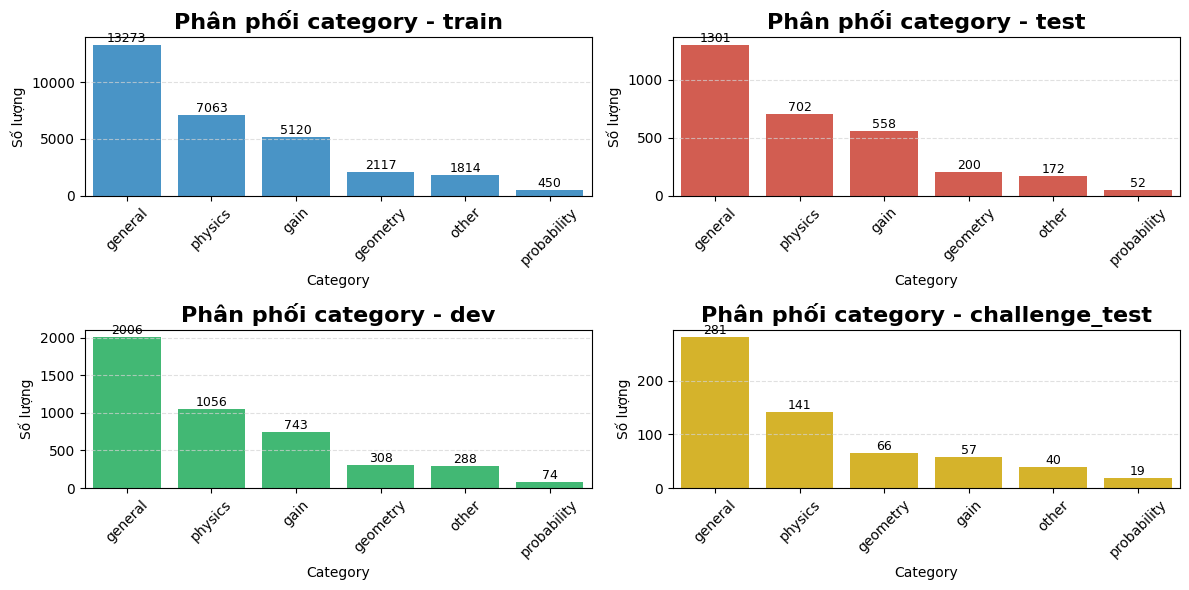

In [5]:
# ----------PHÂN TÍCH CATEGORY ----------
plt.figure(figsize=(12, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f']

for i, (name, df) in enumerate(datasets.items(), 1):
    plt.subplot(2, 2, i)
    
    # Lấy màu tương ứng cho subplot hiện tại
    color = colors[i - 1]

    # Vẽ biểu đồ với 1 màu duy nhất cho tất cả các cột
    ax = sns.countplot(
        data=df,
        x='category',
        order=df['category'].value_counts().index,
        palette=[color]  # dùng danh sách 1 phần tử để áp dụng cho tất cả cột
    )
    
    plt.title(f'Phân phối category - {name}', fontweight='bold',fontsize=16)
    plt.xlabel('Category')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.grid(axis='x', visible=False)
    plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)

    # Hiển thị giá trị trên từng cột
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2,
                    height,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()


### Biểu đồ phân phối các danh mục bài toán trong 4 tập dữ liệu (train, test, dev, challenge_test) cho thấy:

- Danh mục **"general"** chiếm số lượng **lớn nhất** trong tất cả các tập **(khoảng 10.000 ở train, 2.000 ở test/dev, 200 ở challenge_test)**.
- **"Physics", "gain", "geometry"** có số lượng **giảm dần**, với **"physics" khoảng 5.000 (train), "geometry" và "gain" dưới 2.000**.
- **"Other" và "probability" rất ít**, **dưới 1.000** ở tất cả các tập.
- **Insight**: *Tập dữ liệu tập trung vào bài toán "general", ít bài toán về xác suất ("probability") và các loại khác ("other"), phù hợp với mục tiêu học toán tổng quát.*

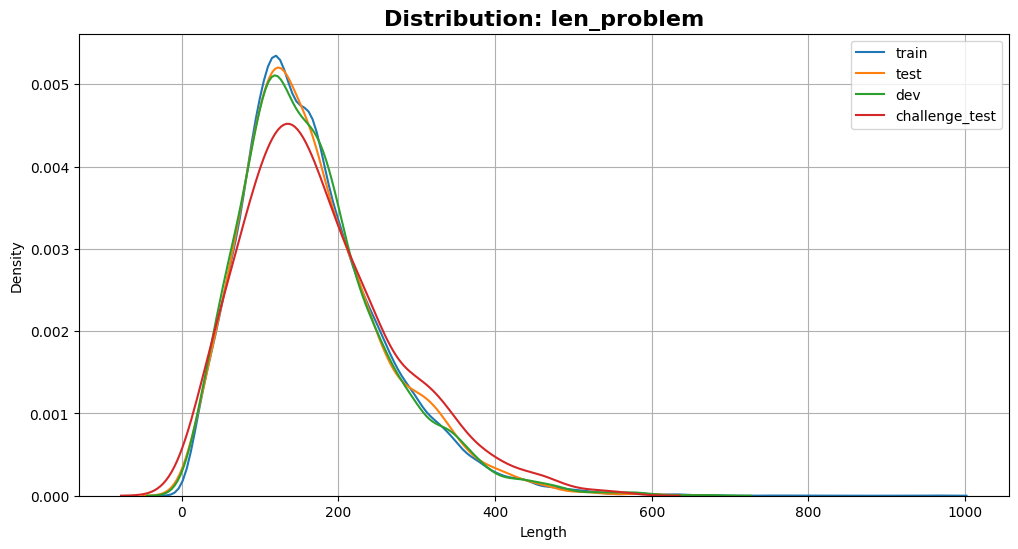

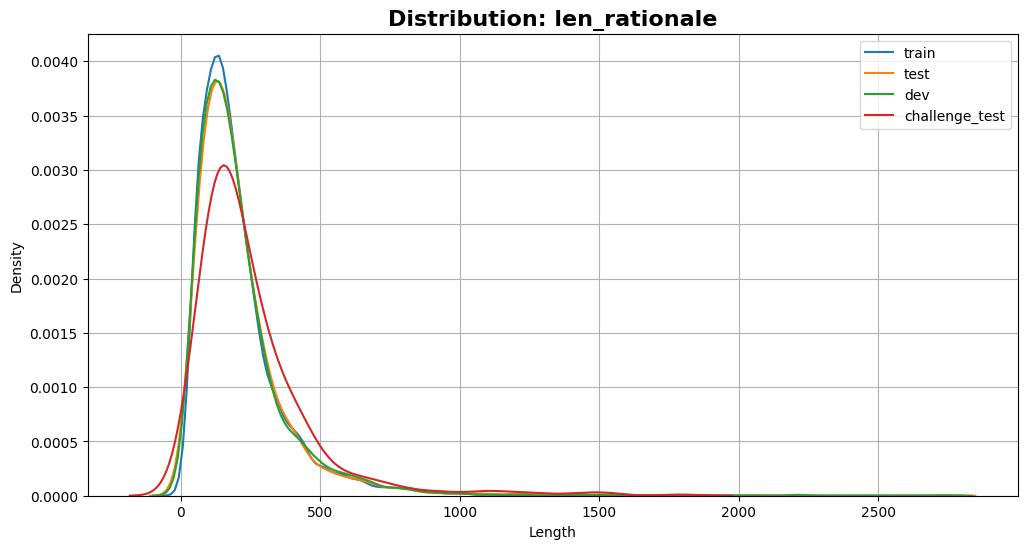

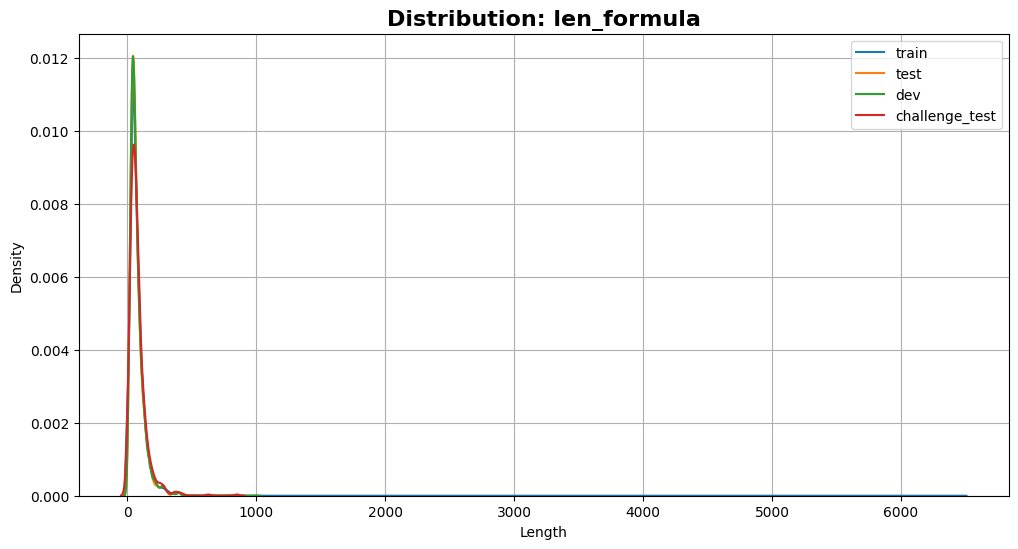

In [6]:
# ----------PHÂN TÍCH ĐỘ DÀI ----------
for length_col in ['len_problem', 'len_rationale', 'len_formula']:
    plt.figure(figsize=(12, 6))
    for name, df in datasets.items():
        sns.kdeplot(df[length_col], label=name)
    plt.title(f'Distribution: {length_col}', fontweight='bold',fontsize=16)
    plt.xlabel('Length')
    plt.legend()
    plt.grid(True)
    plt.show()

### Biểu đồ "Distribution: len_problem"
- Phân phối độ dài câu hỏi (**len_problem**) trong các tập train, test, dev, challenge_test có đỉnh **cao nhất ở khoảng 0-200**, giảm dần sau đó.
- Tất cả **các tập có xu hướng tương đồng**, với đa số độ dài **dưới 400, và rất ít vượt quá 1.000**.
- **Insight**: *Câu hỏi chủ yếu ngắn gọn, tập trung vào các bài toán đơn giản, phù hợp với cấp tiểu học.*

### Biểu đồ "Distribution: len_rationale"
- Phân phối độ dài giải thích (**len_rationale**) cũng **đạt đỉnh ở khoảng 0-500, giảm mạnh sau 1.000.**
- **Tập challenge_test** có đuôi dài hơn (lên **đến 2.500**), **cho thấy giải thích phức tạp hơn.**
- **Insight**: *Giải thích thường ngắn, nhưng bài toán thử thách có thể yêu cầu suy luận dài hơn.*

### Biểu đồ "Distribution: len_formula"
- Phân phối độ dài công thức (**len_formula**) tập trung ở **khoảng 0-1.000**, với **train và challenge_test cao nhất tại đầu**.
- **Rất ít** công thức **vượt quá 2.000**, và gần như không có ở độ dài lớn.
- **Insight**: *Công thức thường ngắn gọn, tập trung vào các phép tính cơ bản, với dữ liệu thử thách có phần đa dạng hơn.*

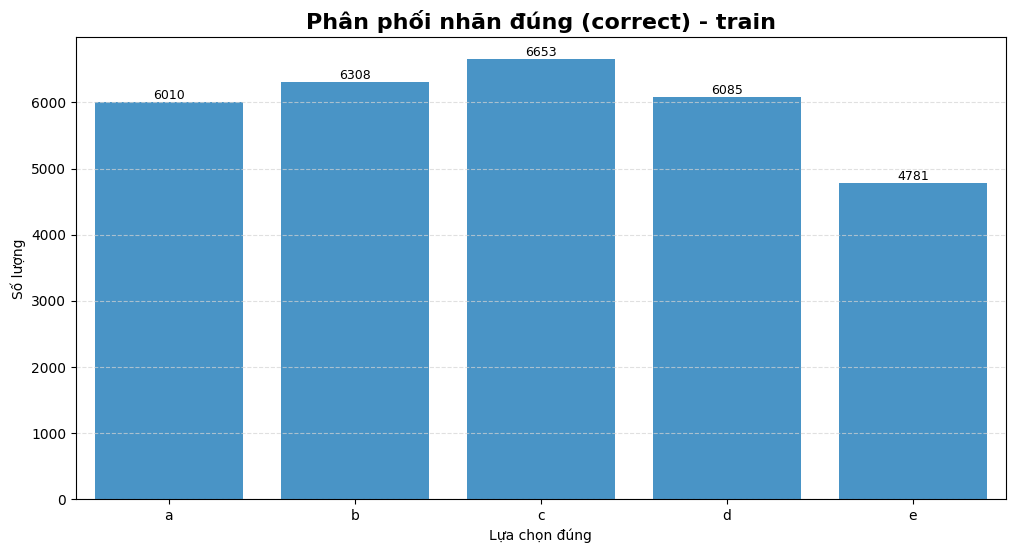

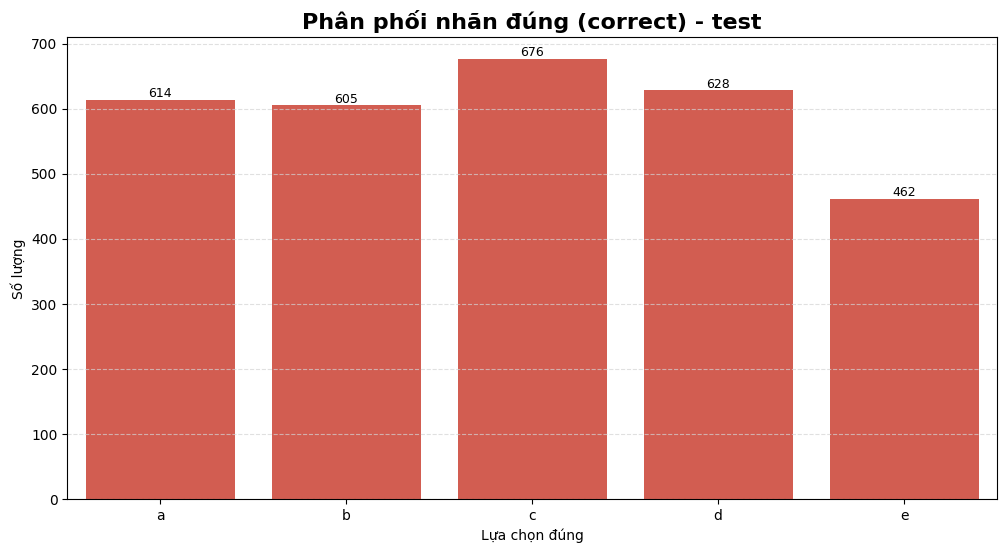

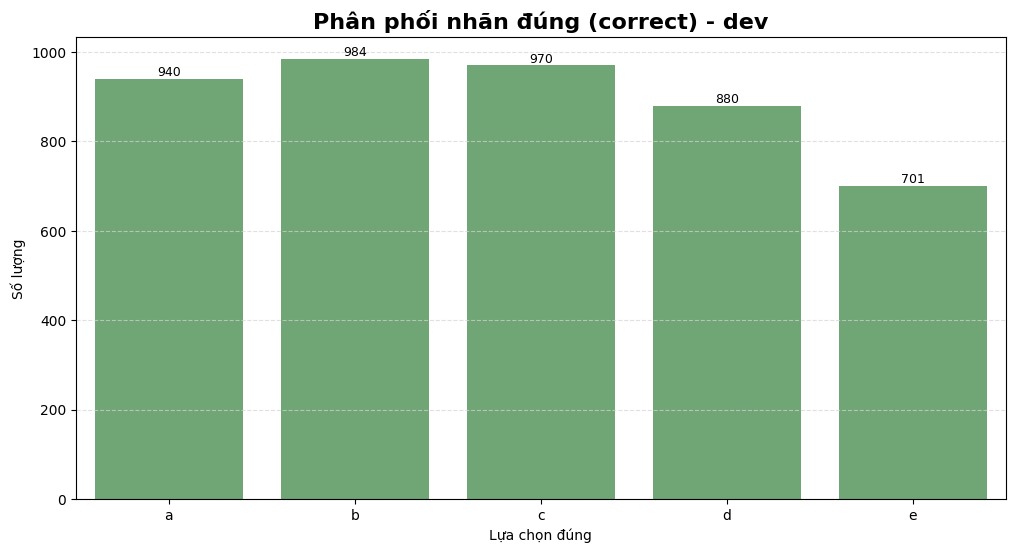

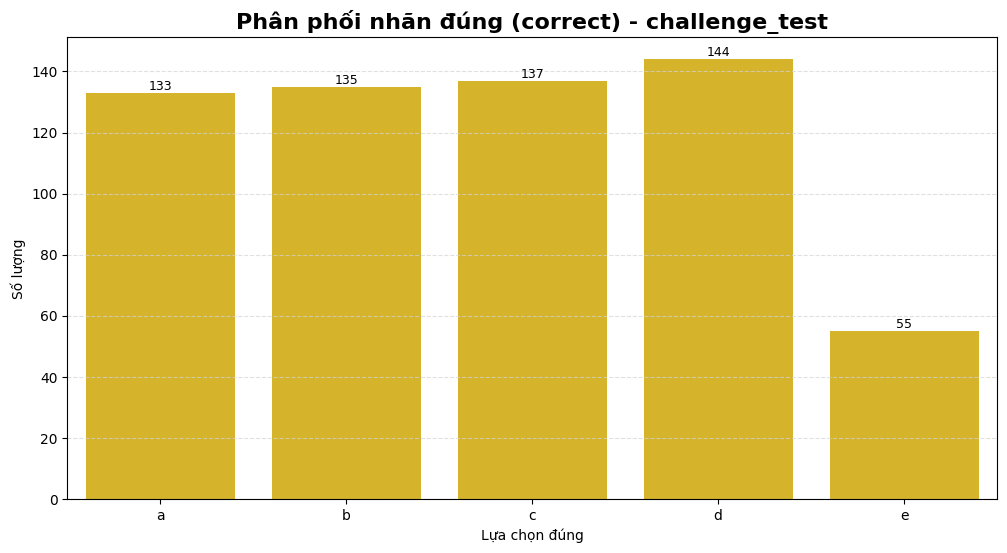

In [7]:
# ----------TỶ LỆ NHÃN ĐÚNG ----------

colors = ['#3498db', '#e74c3c', '#67ae6e', '#f1c40f']

for i, (name, df) in enumerate(datasets.items()):
    plt.figure(figsize=(12, 6))
    
    # Chọn màu tương ứng từ danh sách colors
    color = colors[i % len(colors)]  # dùng % để tránh lỗi nếu có nhiều hơn 4 datasets

    ax = sns.countplot(
        data=df,
        x='correct',
        order=sorted(df['correct'].unique()),
        color=color  # áp dụng màu cho toàn bộ cột
    )
    plt.title(f'Phân phối nhãn đúng (correct) - {name}', fontweight='bold',fontsize=16)
    plt.xlabel('Lựa chọn đúng')
    plt.ylabel('Số lượng')
    plt.grid(axis='x', visible=False)
    plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2,
                    height,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=9)
    plt.show()

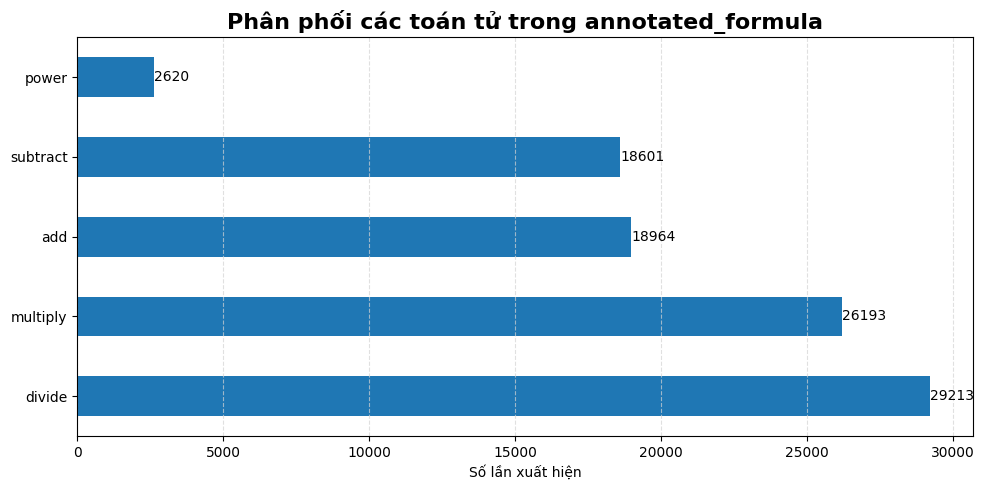

In [8]:
# ----------PHÂN TÍCH FORMULA ----------
all_operators = []
for name, df in datasets.items():
    for formula in df['annotated_formula']:
        for op in ['add', 'subtract', 'multiply', 'divide', 'power']:
            if op in formula:
                all_operators.append(op)

op_series = pd.Series(all_operators).value_counts()

ax = op_series.plot(kind='barh', figsize=(10, 5))
ax.set_title('Phân phối các toán tử trong annotated_formula', fontweight='bold', fontsize=16)
plt.xlabel('Số lần xuất hiện')
plt.grid(axis='y', visible=False)
plt.grid(axis='x', linestyle='--', color='lightgray', alpha=0.7)
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 1,               
                p.get_y() + p.get_height() / 2,  
                int(width), 
                va='center',
                fontsize=10)

plt.tight_layout()
plt.show()

### Biểu đồ "Phân phối các phép toán trong annotated formula" cho thấy:
- Phép **"divide" (chia)** có số lần xuất hiện **cao nhất (gần 3.000)**, tiếp theo là **"multiply" (nhân) và "add" (cộng) (khoảng 2.000-2.500)**.
- Phép **"subtract" (trừ)** thấp hơn một chút **(khoảng 1.500)**, trong khi **"power" (lũy thừa)** rất ít **(dưới 1.000)**.
- **Insight**: *Các phép toán cơ bản như chia, nhân, cộng chiếm ưu thế, trong khi lũy thừa hiếm gặp, phản ánh tập trung vào toán tiểu học cơ bản.*

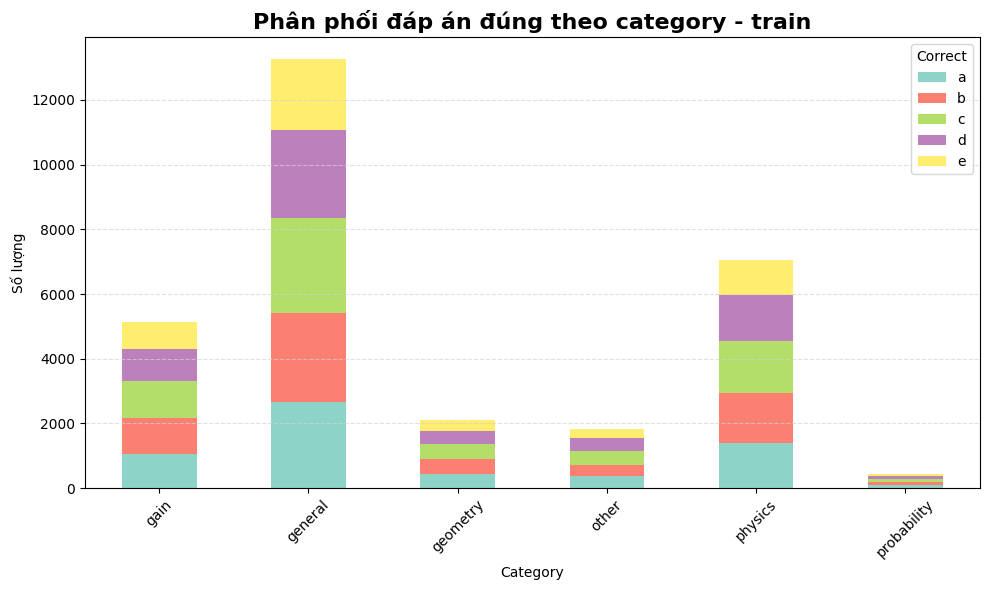

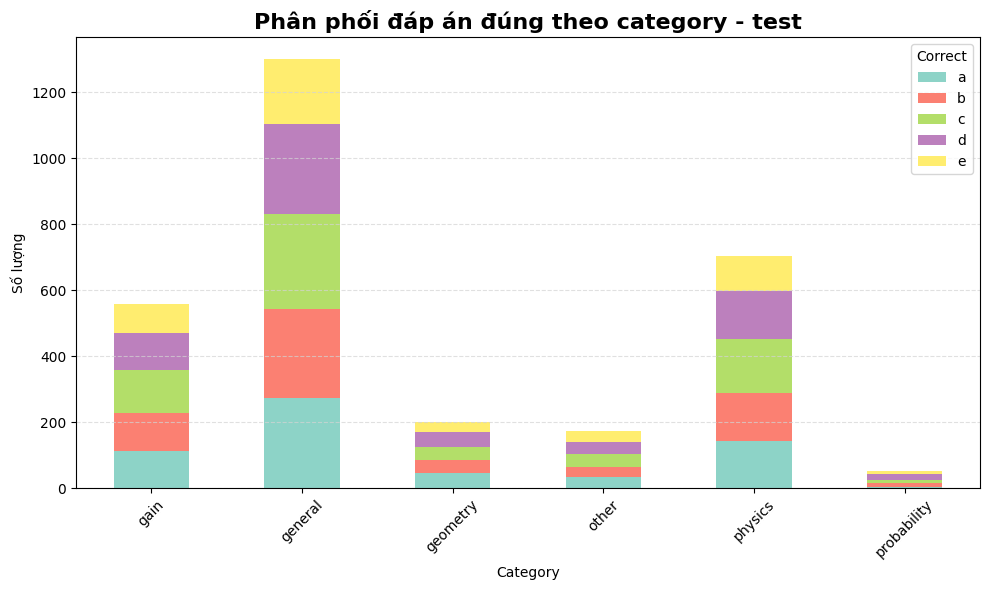

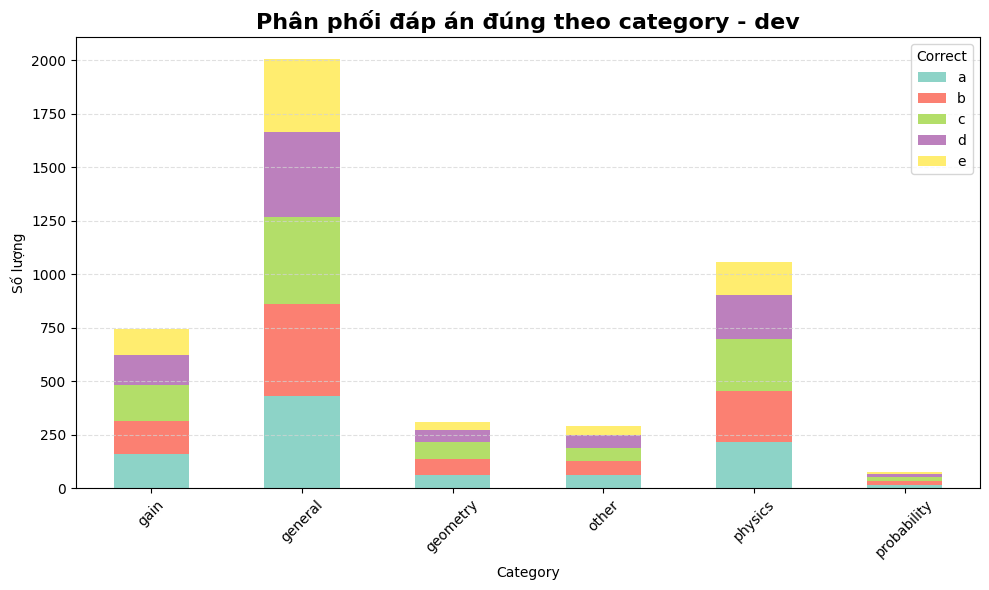

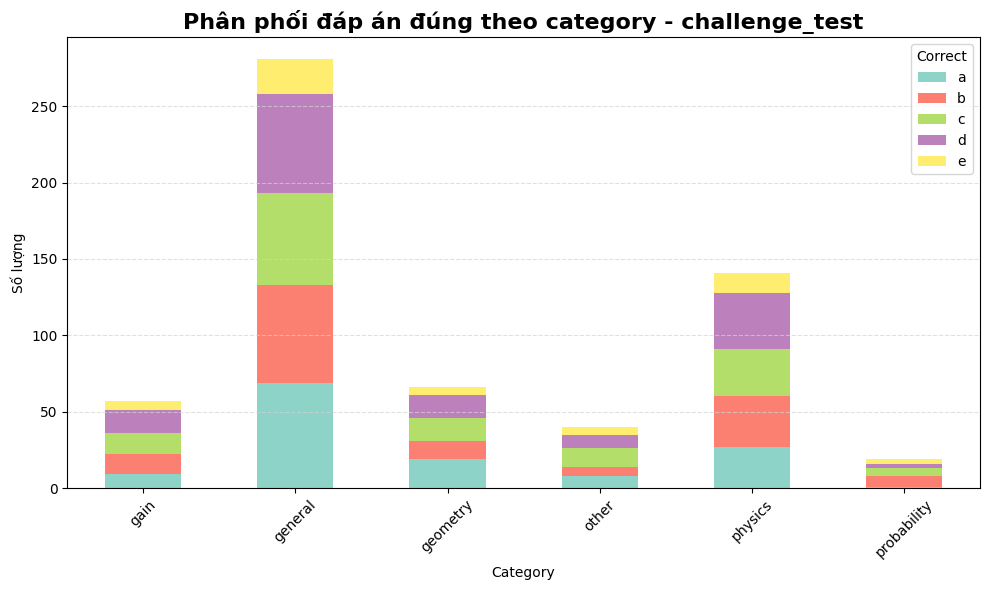

In [9]:
for name, df in datasets.items():
    ct = pd.crosstab(df['category'], df['correct'])
    ct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
    plt.title(f'Phân phối đáp án đúng theo category - {name}', fontweight='bold', fontsize=16)
    plt.xlabel('Category')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.legend(title='Correct')
    plt.grid(axis='x', visible=False)
    plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)
    plt.tight_layout()
    plt.show()

### Biểu đồ "Phân phối đáp án đúng theo danh mục - train/test/dev/challenge_test" cho thấy:
- Danh mục **"general"** có số lượng đáp án **cao nhất** **(khoảng 12.000-2.000 tùy tập)**, chủ yếu đúng (màu xanh).
- **"Physics" và "gain"** có số lượng đáng kể, với **tỷ lệ đúng và sai** (a-e) **tương đối cân bằng**.
- **"Geometry", "other", và "probability"** có số lượng **thấp**, với "probability" gần như không đáng kể.
- **Insight**: *"General" là danh mục chính, tập trung nhiều đáp án đúng, trong khi các danh mục khác ít phổ biến và có sự phân bố đáp án đa dạng hơn.*

In [10]:
for name, df in datasets.items():
        df['num_ops'] = df['annotated_formula'].apply(lambda f: sum(f.count(op) for op in ['add', 'subtract', 'multiply', 'divide', 'power']))
        avg_ops = df['num_ops'].mean()
        print(f"{name}: Trung bình {avg_ops:.2f} toán tử / công thức")

train: Trung bình 4.70 toán tử / công thức
test: Trung bình 4.65 toán tử / công thức
dev: Trung bình 4.66 toán tử / công thức
challenge_test: Trung bình 5.09 toán tử / công thức


### Dựa trên các giá trị trung bình số toán tử mỗi công thức:
- **Train (4.70), test (4.65), và dev (4.66)** có số toán tử tương tự, cho thấy độ phức tạp **đồng đều**.
- **Challenge_test (5.09)** cao hơn rõ rệt, chỉ ra các bài toán thử thách **phức tạp** hơn.
- **Insight**: *Challenge_test đòi hỏi suy luận nhiều bước hơn, phù hợp để kiểm tra khả năng giải quyết vấn đề nâng cao.*

In [11]:
for name, df in datasets.items():
        mismatches = 0
        for _, row in df.iterrows():
            try:
                options = [opt.strip()[0] for opt in row['options'].split(',')]
                if row['correct'] not in options:
                    mismatches += 1
            except:
                mismatches += 1
        print(f"{name}: {mismatches} dòng có nhãn `correct` không trùng với `options`")

train: 842 dòng có nhãn `correct` không trùng với `options`
test: 66 dòng có nhãn `correct` không trùng với `options`
dev: 115 dòng có nhãn `correct` không trùng với `options`
challenge_test: 52 dòng có nhãn `correct` không trùng với `options`


#### Bộ dữ liệu như MathQA cần đảm bảo rằng nhãn correct (đáp án đúng) phải khớp với một trong các lựa chọn trong options. Nếu không, dữ liệu có thể bị lỗi, gây khó khăn cho việc huấn luyện mô hình học máy hoặc kiểm tra.

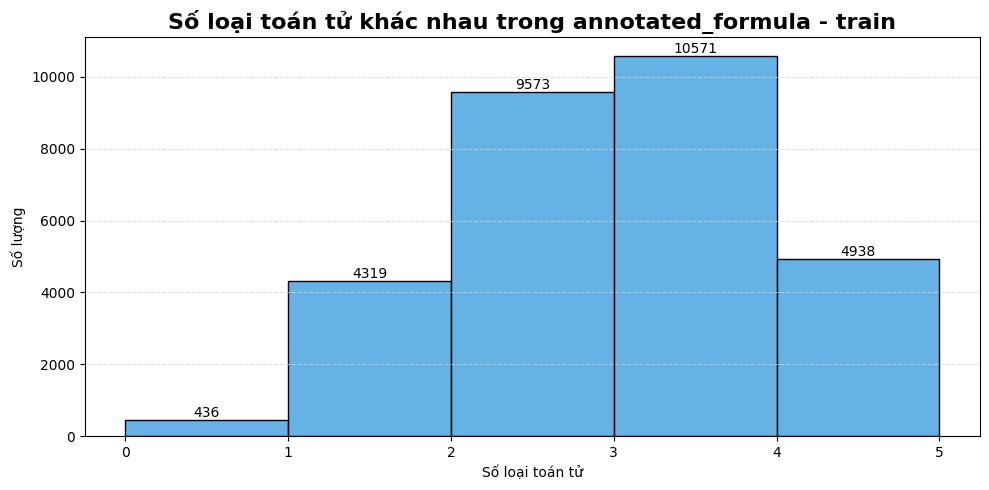

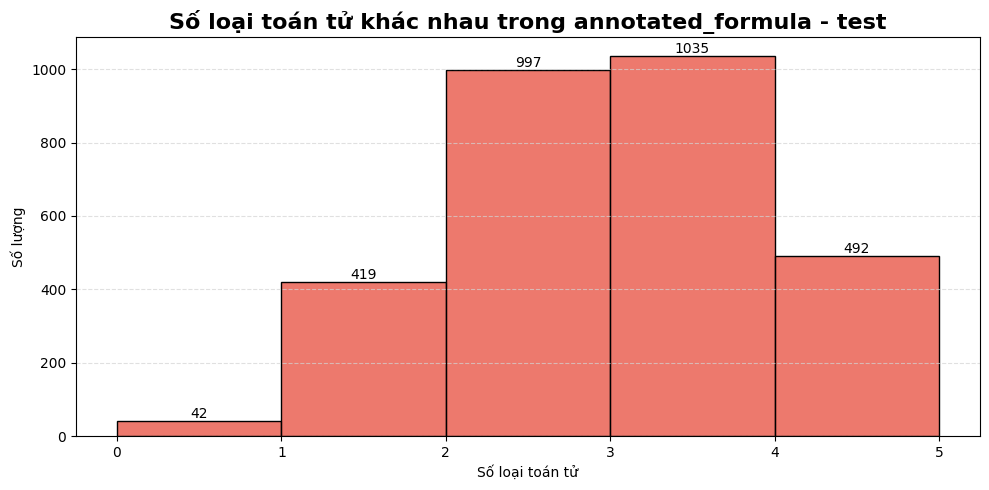

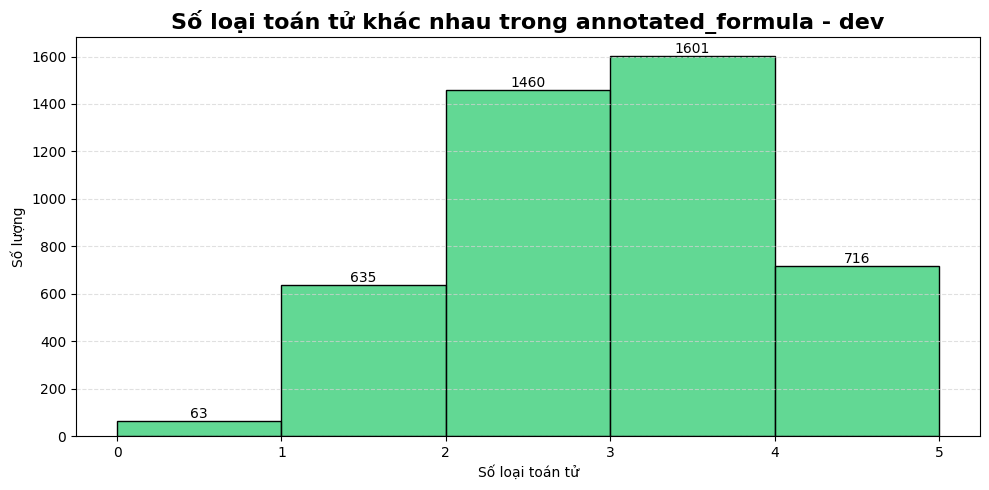

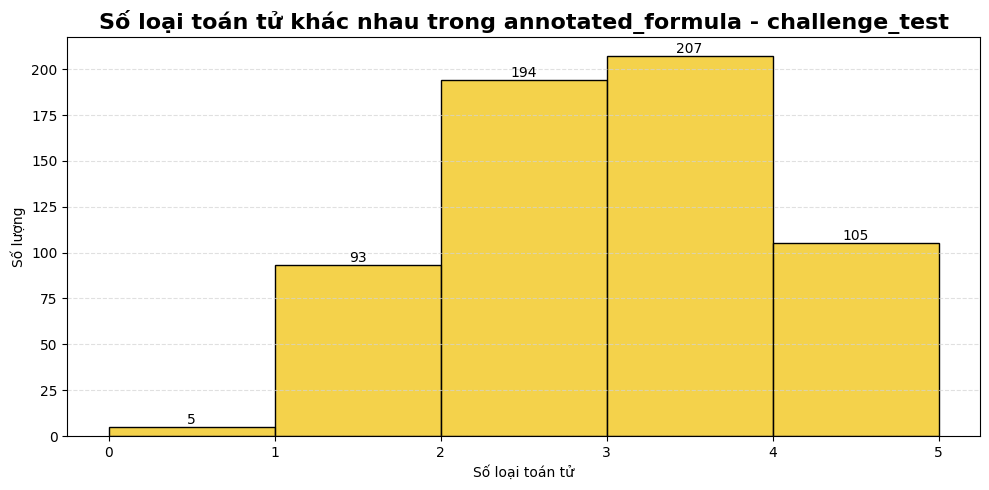

In [12]:
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f1c40f']

for i, (name, df) in enumerate(datasets.items()):
    df['unique_ops'] = df['annotated_formula'].apply(
        lambda f: len(set(op for op in ['add', 'subtract', 'multiply', 'divide', 'power'] if op in str(f)))
    )

    color = colors[i % len(colors)]

    plt.figure(figsize=(10, 5))
    ax = sns.histplot(df['unique_ops'], bins=5, color=color)

    plt.title(f'Số loại toán tử khác nhau trong annotated_formula - {name}', fontweight='bold', fontsize=16)
    plt.xlabel('Số loại toán tử')
    plt.ylabel('Số lượng')
    plt.grid(axis='x', visible=False)
    plt.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2,
                    height,
                    int(height),
                    ha='center',
                    va='bottom',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

### Biểu đồ "Số loại toán tử khác nhau trong annotated_formula" cho thấy:
- Tập **train, test, dev, và challenge_test** đều có **phân bố tương tự**, với đa số công thức chứa 2-3 loại toán tử (đỉnh cao nhất khoảng 3).
- Tập **train** có số lượng **lớn nhất (gần 10.000)**, trong khi **challenge_test nhỏ nhất (dưới 200)**.
- Số công thức chứa 0-1 hoặc 4-5 loại toán tử rất ít.
- **Insight**: *Công thức chủ yếu sử dụng 2-3 loại toán tử, cho thấy độ đa dạng vừa phải, phù hợp với bài toán tiểu học.*